### **Importing the necessary libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

# **Defining functions**

### **Define a function to plot the TSNE and decision boundary plot**

In [2]:
def plot_tsne_decision(model, X_train, y_train, X_test, y_test, title,class_n=3,des_sur=False):
    # The function takes the X and Y points to plot and the label for the plot to be labeled by

    # Define the meshgrid range
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    #If statement to test if it's multi-class classification or binary class to plot the decision surface
    if len(model)>1:
      Z0vr = model[0].predict(np.c_[xx.ravel(), yy.ravel()])
      Z1vr = model[1].predict(np.c_[xx.ravel(), yy.ravel()])
      Z2vr = model[2].predict(np.c_[xx.ravel(), yy.ravel()])
      Z=np.argmax(np.vstack((Z0vr,Z1vr,Z2vr)), axis=0)
      Z = Z.reshape(xx.shape)
    else:
      Z = model[0].predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)

    # Create a color map for the classes
    colors = ['blue', 'red', 'orange']

    # Plot the decision surface
    if des_sur:
      if class_n ==3:
        custom_cmap = plt.cm.colors.ListedColormap(['blue', 'red', 'orange'])
      else:
        color1=colors[class_n]
        if class_n==2:
          color2=colors[class_n-1]
        else:
          color2=colors[class_n+1]
        custom_cmap = plt.cm.colors.ListedColormap([color2, color1])
      plt.figure(figsize=(10, 8))
      plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap=custom_cmap, alpha=0.5)
      plt.contour(xx, yy, Z, levels=1, colors='black', linewidths=1)
      


    # Plot the training data points
    for i in range(3):
        idx = np.where(y_train == i)
        plt.scatter(X_train[idx, 0], X_train[idx, 1], c=colors[i], label='Class ' + str(i), edgecolors='black', marker='o')

    # Plot the test data points
    for i in range(3):
        idx = np.where(y_test == i)
        plt.scatter(X_test[idx, 0], X_test[idx, 1], c=colors[i], label='Class ' + str(i) + ' (Test)', edgecolors='black', marker='x')

    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.title(f'{title}')
    plt.legend(fontsize=7)
    plt.show()

### **A function to plot the confusion matrix**

In [3]:
def confusion_mx (y_test,y_pred,label):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True,fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix {label}',size= 10)
    plt.show()

### **Define the accuracy funtion**

In [4]:
def getAccuracy(model, x, y):
    return model.score(x,y)*100

### **A function to label encode our target data for the one-vs-rest SVM model**

In [5]:
def ovr_encoder(data,main_class): # the function takes the data to encode and the main class to be labeled as 1
  data = np.where(data == main_class, 42, data) # label the main class as 42
  data = np.where(data != 42, 0, data) #label data other than 42 as 0
  data = np.where(data == 42, 1, data)# label the main class previously labeld as 42 to 1
  return data

### **function to run any model on the one-vs-rest data**

In [6]:
def ovr_class(main_class,model): #takes the main class and the model

#label the train and test target data for the main class as 1 and other data as 0
  Y_Train_new = ovr_encoder(Y_Train,main_class)
  Y_Test_new = ovr_encoder(Y_Test,main_class)

#Fit the model to training data
  mod=model.fit(X_Train , Y_Train_new)
  y_pred_train = mod.predict(X_Train)

#Plotting the confusion matrix for the model for training data
  confusion_mx(Y_Train_new , y_pred_train,"For Training Data")
  print('Accuracy of model \'Train\': {:.2f}%'.format(getAccuracy(mod, X_Train, Y_Train_new)))

#Plotting the confusion matrix for the model for testing data
  y_pred_test = mod.predict(X_Test)
  confusion_mx(Y_Test_new , y_pred_test,"For Test Data")
  print('Accuracy of model \'Test\': {:.2f}%'.format(getAccuracy(mod, X_Test, Y_Test_new)))
  plot_tsne_decision([mod], X_Train, Y_Train, X_Test, Y_Test,f"Decision Surface for Class {main_class} vs rest",class_n=main_class,des_sur=True)
  plt.tight_layout()
  return y_pred_train,y_pred_test,mod #Return the model to use when plotting aggregated models results


### **A function to aggregate the results of training data or testing data**

In [7]:
def aggre(lst1,lst2,lst3):
  combined_array = np.array([lst1, lst2, lst3])
  res = np.argmax(combined_array, axis=0)
  return res

### **Function to Split the data to 2 different sets with a given size of each**

In [8]:
def split_data(x , y , train_size , test_size) :
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = train_size  , test_size = test_size, shuffle = True , random_state = 42)
    return X_train, X_test, y_train, y_test

### **Function to encode the categorical dataframe to a numerical one**

In [9]:
def encode_categorical_df(df):
    le = LabelEncoder()  
    for column in df.columns:
        if df[column].dtype == 'object':  
            df[column] = le.fit_transform(df[column])  
    return df

### **Function to encode the categorical columns to numerical**

In [10]:
def encode_categorical_column(col) :
    le = LabelEncoder()  
    col = le.fit_transform(col)
    return col     

### **Function to get the Accuracy Score for a model**

In [11]:
def get_accuracy(y_test , y_pred):
    result = accuracy_score(y_test,y_pred) * 100
    return result

### **Function to plot the Accuracy Score vs Train size and Number of Ks**

In [12]:
def plot_accuracy( accuracy , percent_list , color  , label , marker):
    plt.plot(percent_list , accuracy , color = color , label = label , marker = marker)
    plt.legend()

### **Function to split the train data to a needed percent**

In [13]:
def percent_split(x_train , y_train , percent):
    subset_size = int(len(x_train) * (percent/100))
    x_train = x_train[:subset_size]
    y_train = y_train[:subset_size]
    return x_train , y_train

### **Function to train the KNN model with Number of Neighbors equal 2**

**we try with a different test size from 10 to 100 percent then plot the test and validation Accuracy per each split**

In [14]:
def KNN_X_train_size(x_train , y_train , x_test , y_test , x_val , y_val , percent_list ):
    
    knn = KNeighborsClassifier(n_neighbors = 2)
    test_accuracy_list , val_accuracy_list = [] , []
    for percent in percent_list :
        
        x_split , y_split =  percent_split(x_train , y_train , percent)
        model = knn.fit(x_split , y_split)
        y_test_pred = model.predict(x_test)
        y_val_pred = model.predict(x_val)
        test_accuracy_list.append(get_accuracy(y_test , y_test_pred))
        val_accuracy_list.append(get_accuracy(y_val , y_val_pred))
    formatted_test_results = ["{:.2f}".format(result) for result in test_accuracy_list]
    print("Accuracy for test data : " , formatted_test_results , " % ")
    formatted_validation_results = ["{:.2f}".format(result) for result in val_accuracy_list]
    print("Accuracy for validation data : " , formatted_validation_results , " % ")
    plot_accuracy(test_accuracy_list , percent_list ,"r" , label = "test data" , marker = ".")
    plot_accuracy(val_accuracy_list , percent_list , "b" , label = "validation data" , marker = ".")
    plt.xlabel("Train Size (Percent %)")
    plt.ylabel("Accuracy Score (percent %)")
    plt.title("Test vs Validation Accuracy Score")
    plt.show() 

### **Function to to train the KNN model with multiple Number of Neighbors**

**We try with multiple numbers of K from 1 to 10 with 100% of the training data**

In [15]:
def KNN_X_K(x_train , y_train , x_test , y_test , x_val , y_val):
    k_list = list(range(1,11))
    val_accuracy_list = [] 
    for k in k_list :
        knn = KNeighborsClassifier(n_neighbors = k)
        model = knn.fit(x_train , y_train)
        y_val_pred = model.predict(x_val)
        val_accuracy_list.append(get_accuracy(y_val , y_val_pred))
    formatted_validation_results = ["{:.2f}".format(result) for result in val_accuracy_list]
    print("Accuracy for validation data : " , formatted_validation_results , " % ")    
    plot_accuracy(val_accuracy_list , k_list , "b" , label = "validation data" , marker = ".")
    plt.xlabel("Number of Ks")
    plt.ylabel("Accuracy Score (Percent %)")
    plt.title("Validation Number of Ks")
    plt.show()


# **1.**

**Readin data**

In [16]:
X_Train = np.array([[1.3, 3.3], [1.4, 2.5], [1.8, 2.8], [1.9, 3.1], [1.5, 1.5], [1.8, 2], [2.3, 1.9], [2.4, 1.4], [2.4, 2.4], [2.4, 3], [2.7, 2.7], [2.3, 3.2]])
Y_Train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

X_Test = np.array([[1.7, 2.5], [1.9, 2.7], [2, 2.15], [2.4, 2], [2.2, 3.25], [2.4, 2.25]])
Y_Test = np.array([0, 0, 1, 1, 2, 2])

## **1. a)**

### **Initializing SVM with default parameters and fitting the model to the training data**

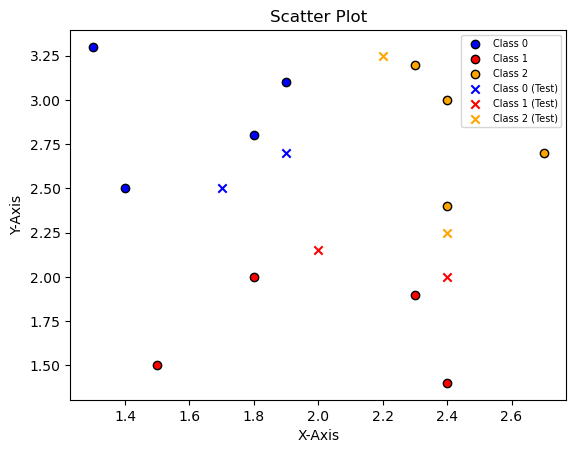

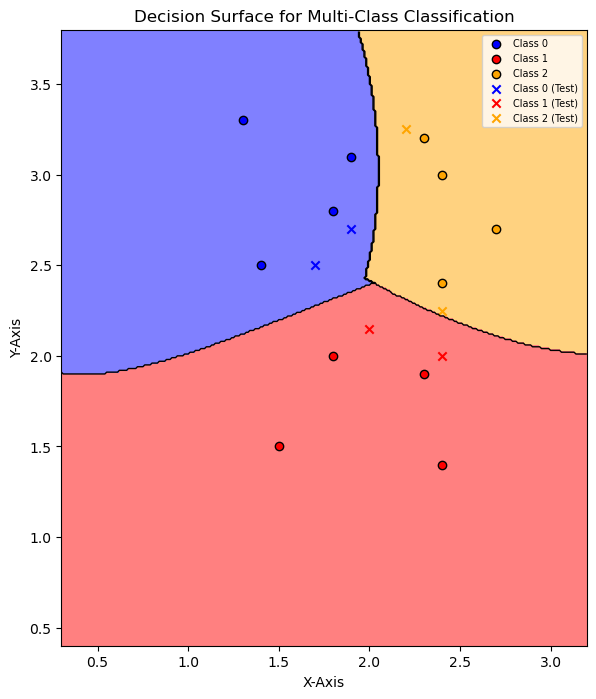

In [17]:
svm = SVC() 
svm=svm.fit(X_Train , Y_Train)
y_pred = svm.predict(X_Train)
#plotting the data without the decision boundary
plot_tsne_decision([svm], X_Train, Y_Train, X_Test, Y_Test, "Scatter Plot") 
#plotting the data with the decision boundary
plot_tsne_decision([svm], X_Train, Y_Train, X_Test, Y_Test,"Decision Surface for Multi-Class Classification",des_sur=True) 

### **Plotting the confusion matrices for train and test data**

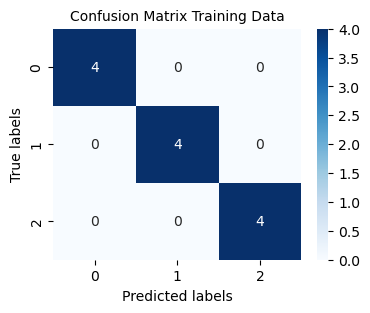

Accuracy of model: 100.00%


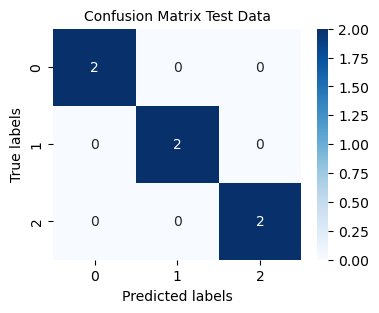

Accuracy of model: 100.00%


In [18]:
y_pred = svm.predict(X_Train)
confusion_mx(Y_Train , y_pred,"Training Data")
print('Accuracy of model: {:.2f}%'.format(getAccuracy(svm, X_Test, Y_Test)))
y_pred = svm.predict(X_Test)
confusion_mx(Y_Test , y_pred,"Test Data")
print('Accuracy of model: {:.2f}%'.format(getAccuracy(svm, X_Test, Y_Test)))

## **1. b) For SVM**

**call the ovr_class function to label class 0 as the main class and passing the model with new parameters to the function and display the confusion matrices for train and test data and plot the decision**

### **Class 0 as main class**

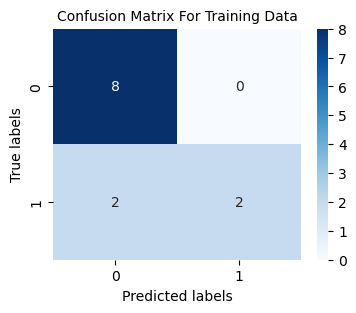

Accuracy of model 'Train': 83.33%


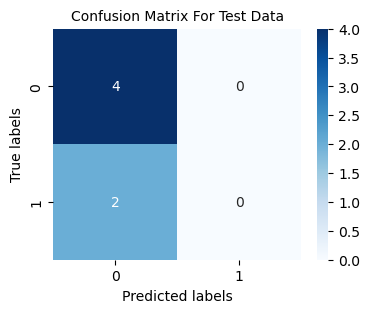

Accuracy of model 'Test': 66.67%


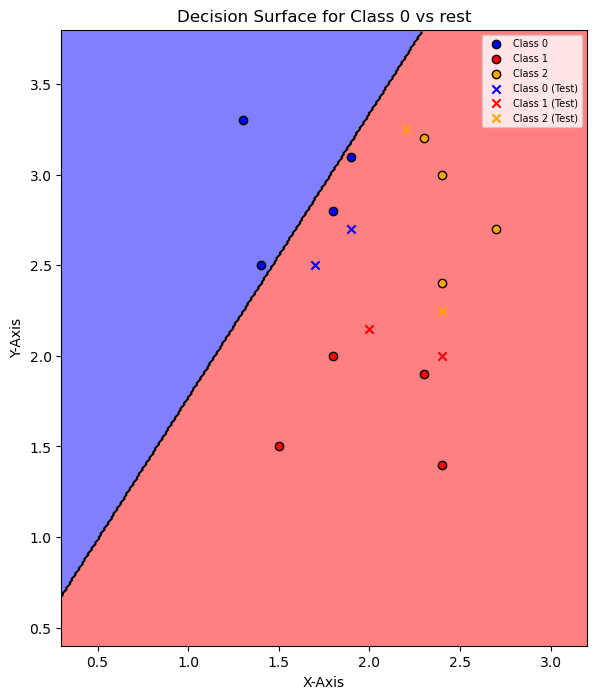

<Figure size 640x480 with 0 Axes>

In [19]:
pred_0_train,pred_0_test,mod0 = ovr_class(0,SVC(kernel='linear'))

### **Class 1 as main class**

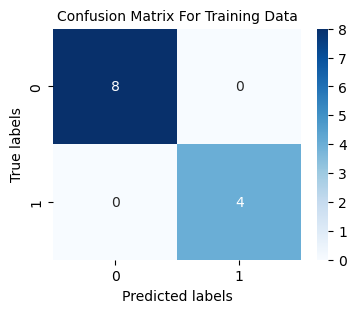

Accuracy of model 'Train': 100.00%


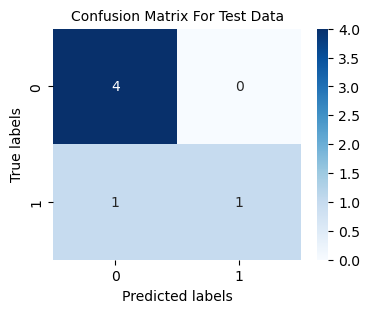

Accuracy of model 'Test': 83.33%


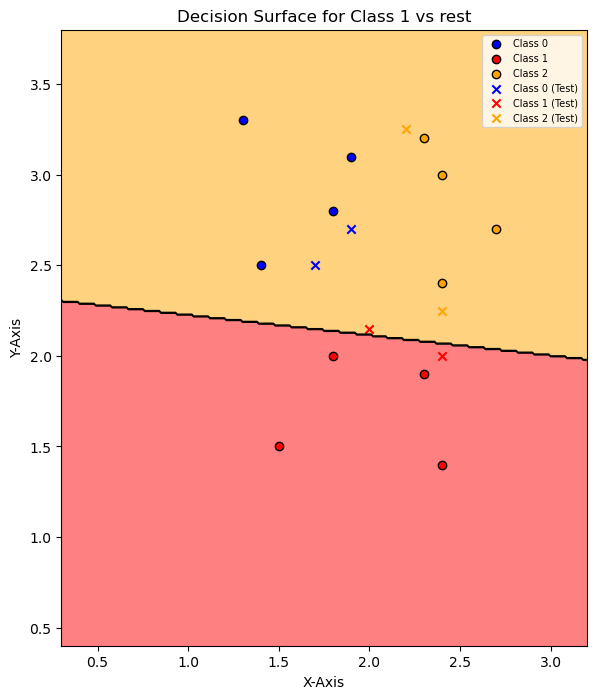

<Figure size 640x480 with 0 Axes>

In [20]:
pred_1_train,pred_1_test,mod1 = ovr_class(1,SVC(kernel='linear'))

### **Class 2 as main class**

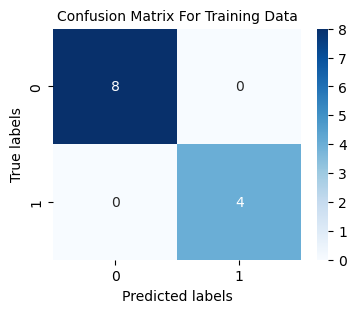

Accuracy of model 'Train': 100.00%


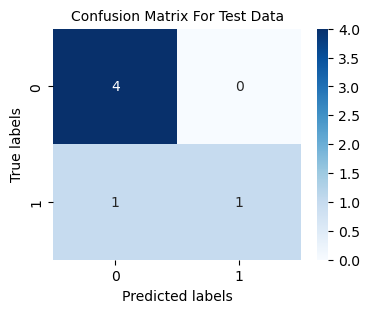

Accuracy of model 'Test': 83.33%


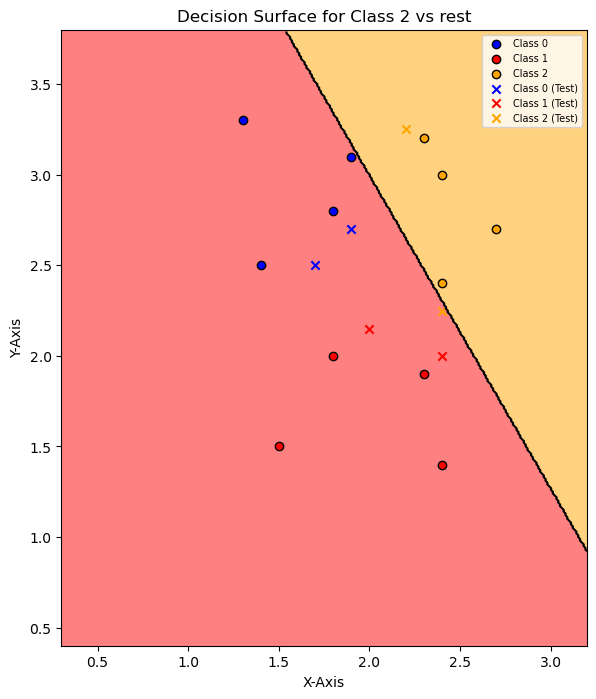

<Figure size 640x480 with 0 Axes>

In [21]:
pred_2_train,pred_2_test,mod2 = ovr_class(2,SVC(kernel='linear'))

## **1. b) For Perceptron**

### **Class 0 as main class**

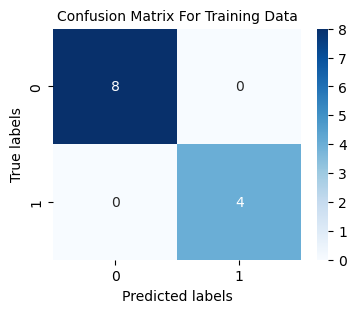

Accuracy of model 'Train': 100.00%


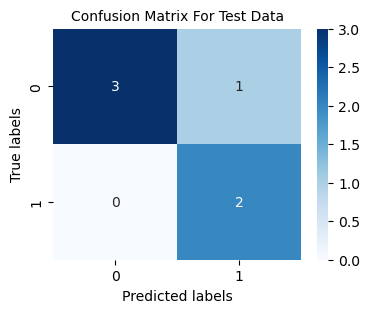

Accuracy of model 'Test': 83.33%


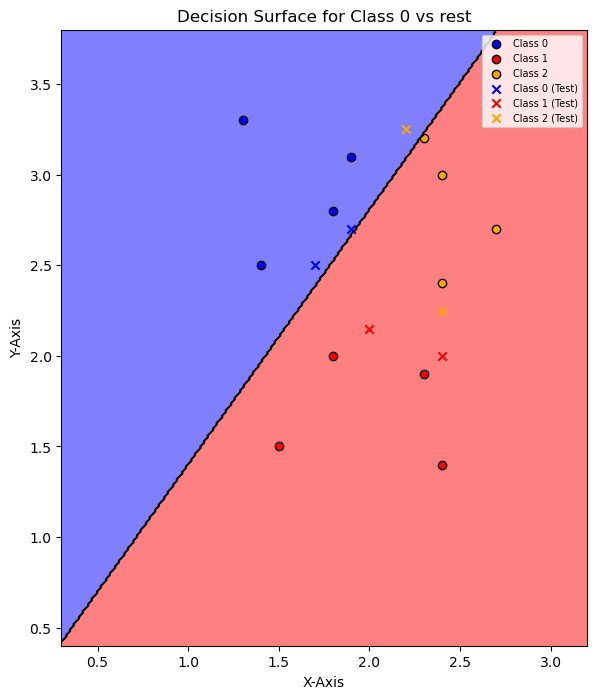

<Figure size 640x480 with 0 Axes>

In [22]:
predp_0_train,predp_0_test,mod0_p = ovr_class(0,Perceptron())

### **Class 1 as main class**

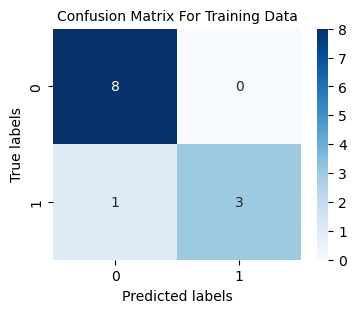

Accuracy of model 'Train': 91.67%


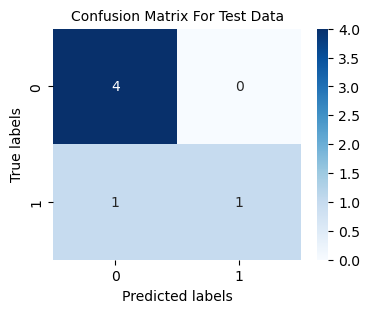

Accuracy of model 'Test': 83.33%


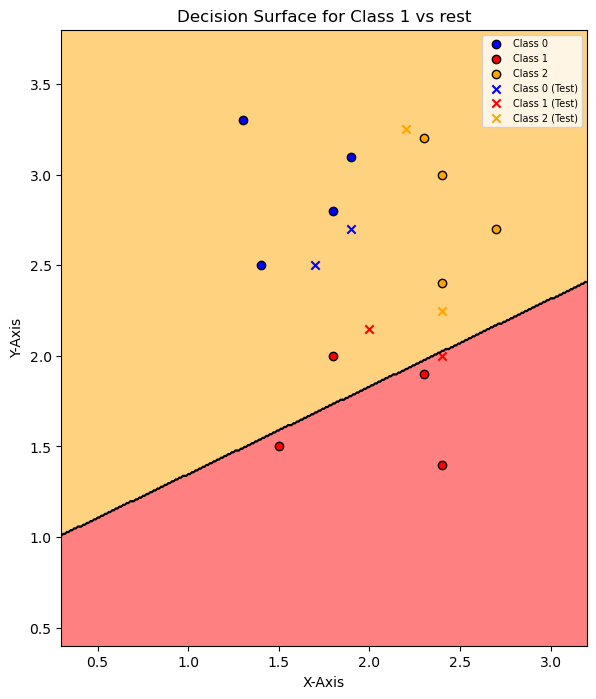

<Figure size 640x480 with 0 Axes>

In [23]:
predp_1_train,predp_1_test,mod1_p = ovr_class(1,Perceptron())

### **Class 2 as main class**

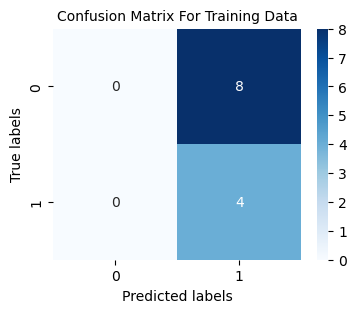

Accuracy of model 'Train': 33.33%


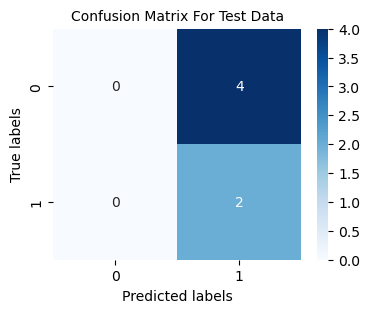

Accuracy of model 'Test': 33.33%


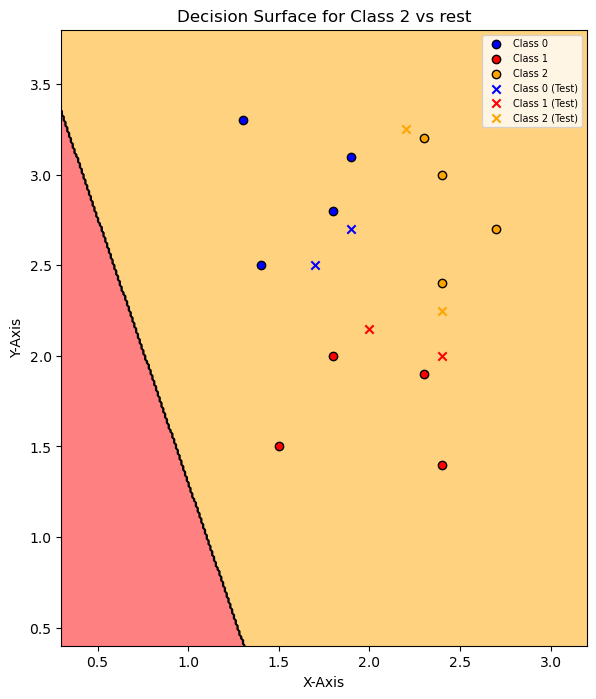

<Figure size 640x480 with 0 Axes>

In [24]:
predp_2_train,predp_2_test,mod2_p = ovr_class(2,Perceptron())

## **1. c) For SVM**

### **Aggregate training data and testing data and plot results**

In [25]:
y_aggregated_train = aggre(pred_0_train,pred_1_train,pred_2_train)
y_aggregated_test = aggre(pred_0_test,pred_1_test,pred_2_test)

**Plotting confusion matrices for aggregated training data with original train data and aggregated test data with original test data**

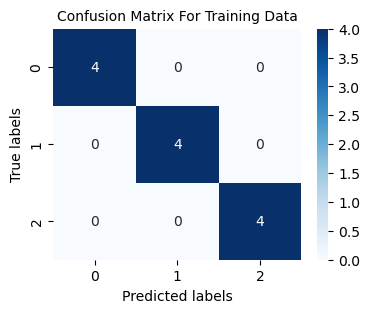

Accuracy of model: 100.0 %


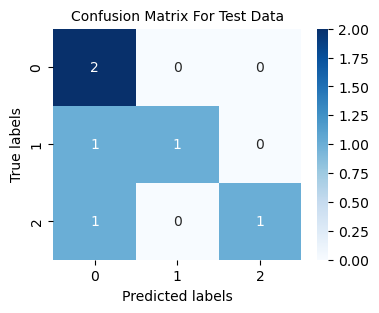

Accuracy of model: 66.66666666666666 %


In [26]:
confusion_mx(Y_Train, y_aggregated_train, "For Training Data")
print(f'Accuracy of model: {(accuracy_score(Y_Train,y_aggregated_train))*100} %')
confusion_mx(Y_Test, y_aggregated_test, "For Test Data")
print(f'Accuracy of model: {(accuracy_score(Y_Test,y_aggregated_test))*100} %')

### **Plot the aggregated data with test data and display the decision boundary**

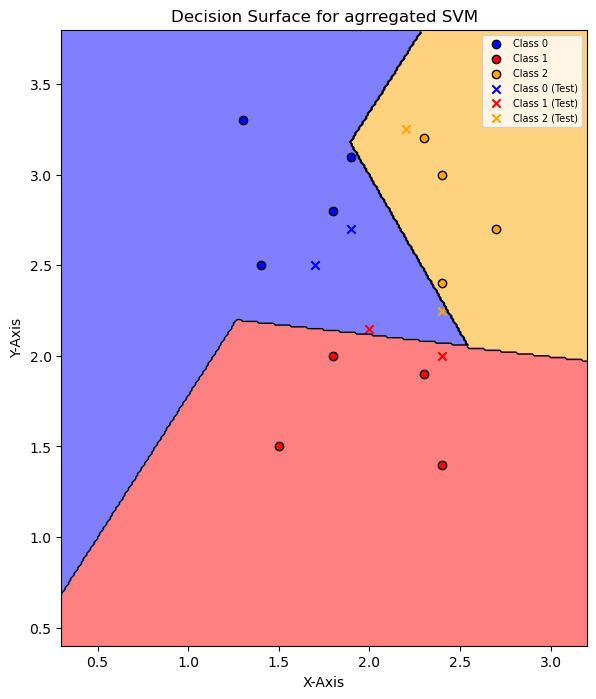

In [27]:
plot_tsne_decision([mod0,mod1,mod2], X_Train, Y_Train, X_Test, Y_Test,"Decision Surface for agrregated SVM",des_sur=True)

## **1. c)For Perceptron**

### **Aggregate training data and testing data and plot results**

In [28]:
yp_aggregated_train = aggre(predp_0_train,predp_1_train,predp_2_train)
yp_aggregated_test = aggre(predp_0_test,predp_1_test,predp_2_test)

**Plotting confusion matrices for aggregated training data with original train data and aggregated test data with original test data**

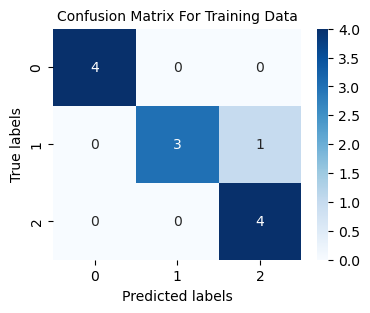

Accuracy of model: 91.66666666666666 %


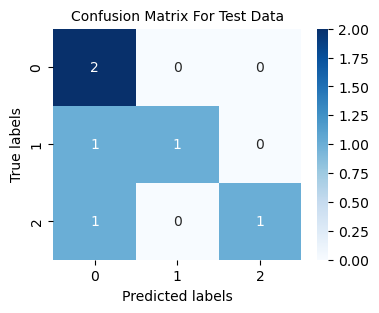

Accuracy of model: 66.66666666666666 %


In [29]:
confusion_mx(Y_Train, yp_aggregated_train, "For Training Data")
print(f'Accuracy of model: {(accuracy_score(Y_Train,yp_aggregated_train))*100} %')
confusion_mx(Y_Test, y_aggregated_test, "For Test Data")
print(f'Accuracy of model: {(accuracy_score(Y_Test,yp_aggregated_test))*100} %')

### **Plot the aggregated data with test data and display the decision boundary**

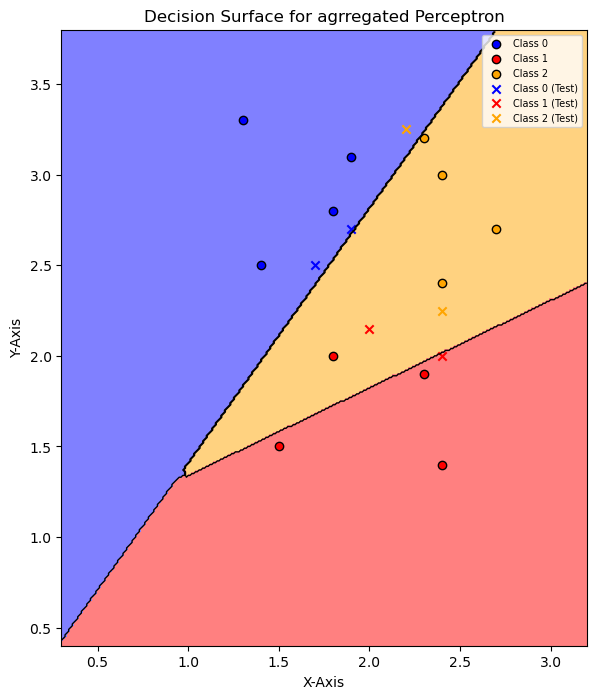

In [30]:
plot_tsne_decision([mod0_p,mod1_p,mod2_p], X_Train, Y_Train, X_Test, Y_Test,"Decision Surface for agrregated Perceptron",des_sur=True)

## **1. d)**

**Refining the parameters of the model**

### **Trying with multi-class classification**

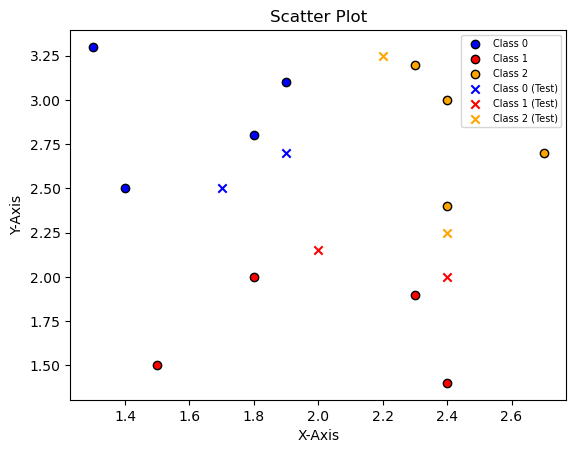

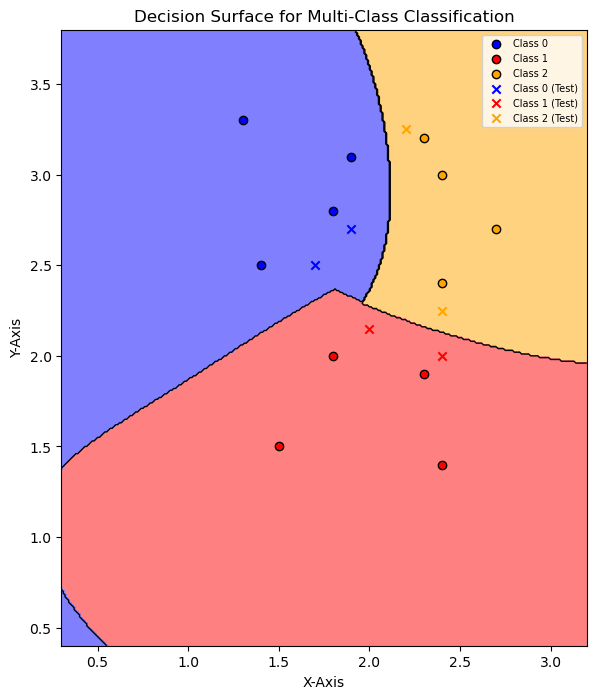

In [31]:
svm = SVC(C=5) 
svm=svm.fit(X_Train , Y_Train)
y_pred = svm.predict(X_Train)
plot_tsne_decision([svm], X_Train, Y_Train, X_Test, Y_Test, "Scatter Plot") #plotting the data without the decision boundary
plot_tsne_decision([svm], X_Train, Y_Train, X_Test, Y_Test,"Decision Surface for Multi-Class Classification",des_sur=True) #plotting the data with the decision boundary

### **Plotting the confusion matrices for train and test data**

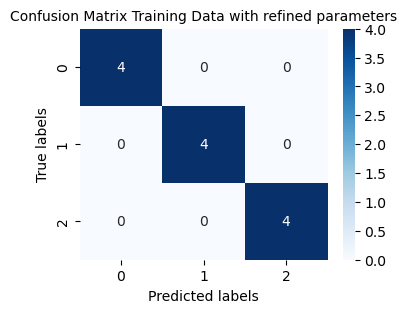

Accuracy of model: 100.00%


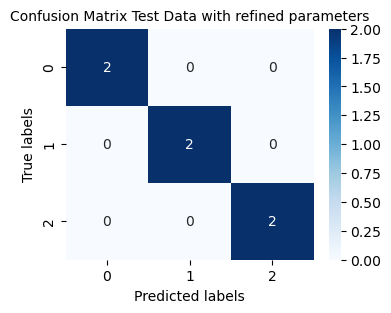

Accuracy of model: 100.00%


In [32]:
y_pred = svm.predict(X_Train)
confusion_mx(Y_Train , y_pred,"Training Data with refined parameters")
print('Accuracy of model: {:.2f}%'.format(getAccuracy(svm, X_Test, Y_Test)))
y_pred = svm.predict(X_Test)
confusion_mx(Y_Test , y_pred,"Test Data with refined parameters")
print('Accuracy of model: {:.2f}%'.format(getAccuracy(svm, X_Test, Y_Test)))

### **Trying with binary class classification**

**Class 0 as main class**

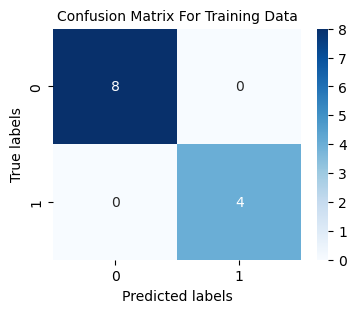

Accuracy of model 'Train': 100.00%


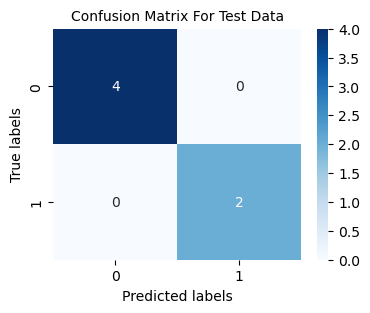

Accuracy of model 'Test': 100.00%


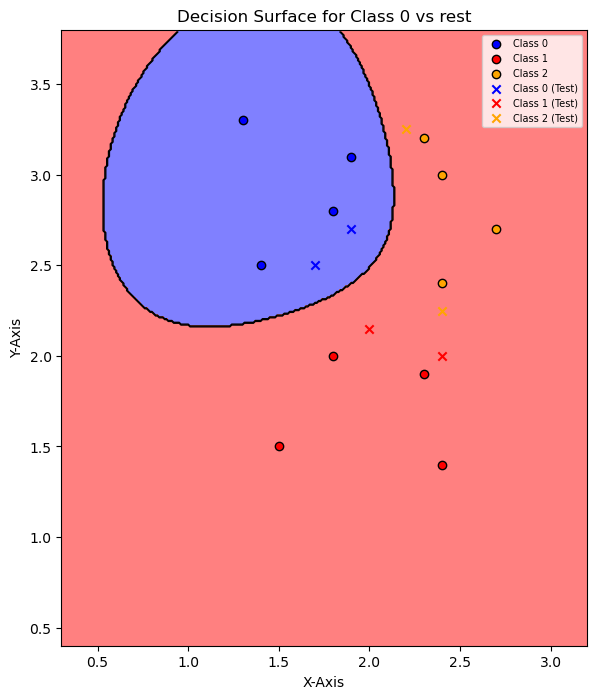

<Figure size 640x480 with 0 Axes>

In [33]:
pred_0_train,pred_0_test,bla0 = ovr_class(0,SVC(C=5)) # Trying the new model with class 0 as main class

**Class 1 as main class**

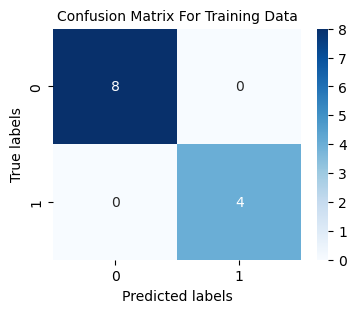

Accuracy of model 'Train': 100.00%


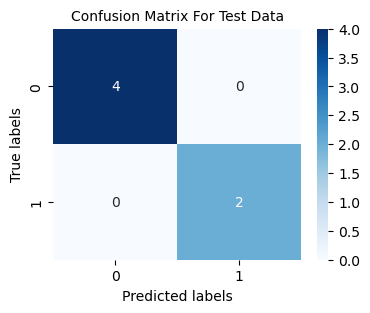

Accuracy of model 'Test': 100.00%


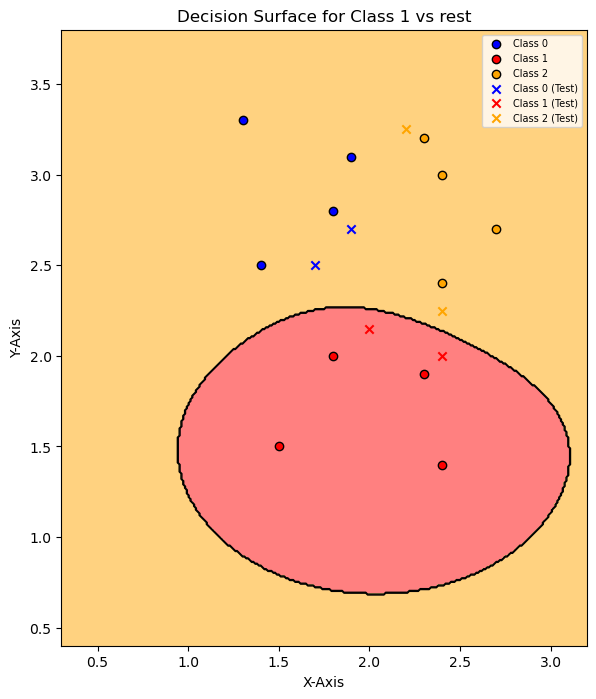

<Figure size 640x480 with 0 Axes>

In [34]:
pred_1_train,pred_1_test,bla1 = ovr_class(1,SVC(C=5))

**Class 2 as main class**

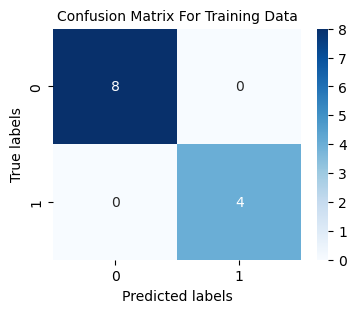

Accuracy of model 'Train': 100.00%


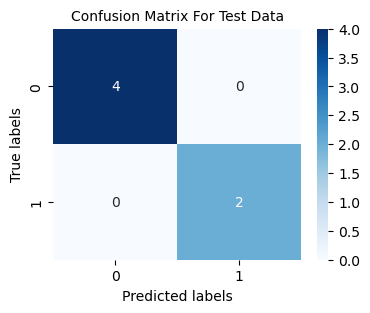

Accuracy of model 'Test': 100.00%


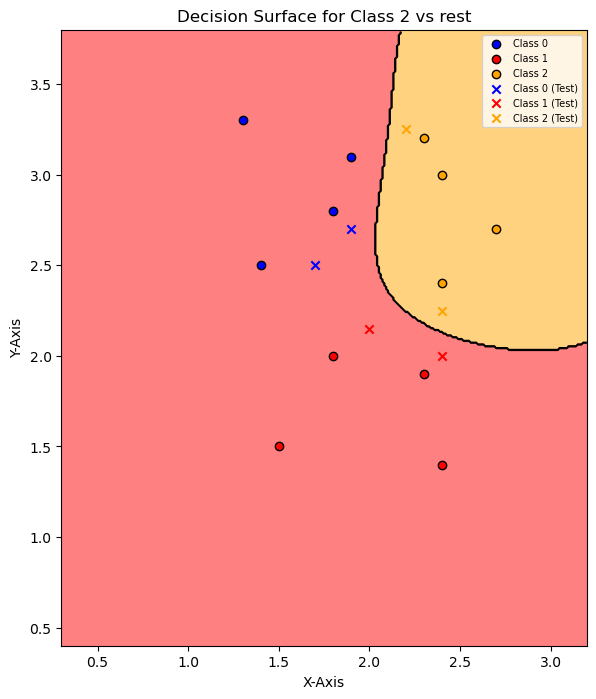

<Figure size 640x480 with 0 Axes>

In [35]:
pred_2_train,pred_2_test,bla2 = ovr_class(2,SVC(C=5))

### **Aggregate the results for new model**

In [36]:
y_aggregated_train = aggre(pred_0_train,pred_1_train,pred_2_train)
y_aggregated_test = aggre(pred_0_test,pred_1_test,pred_2_test)

### **Plotting Decision surface**

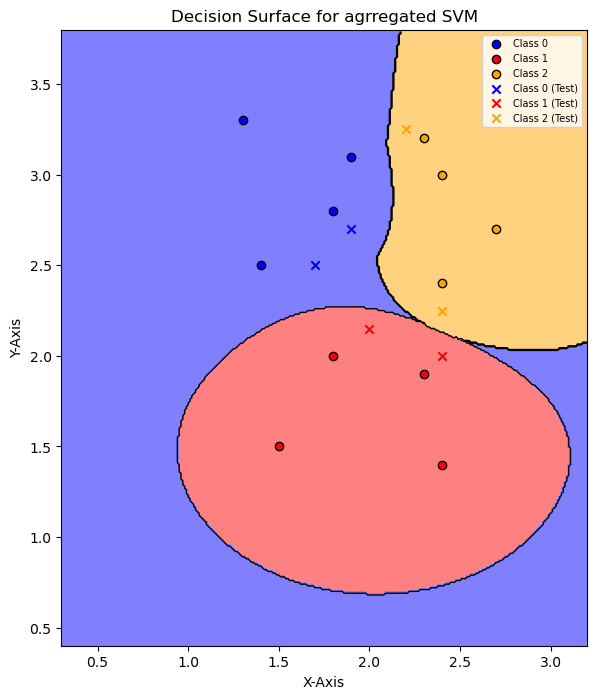

In [37]:
plot_tsne_decision([bla0,bla1,bla2], X_Train, y_aggregated_train, X_Test, y_aggregated_test,"Decision Surface for agrregated SVM",des_sur=True)

### **Displaying the confusion matrices for new aggregated results**

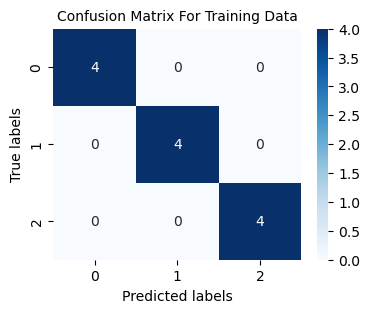

Accuracy of model: 100.0%


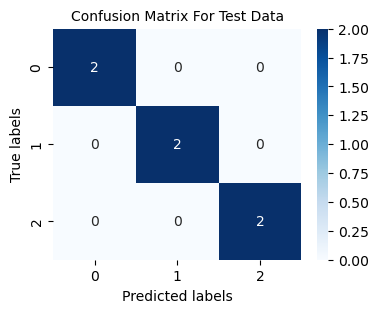

Accuracy of model: 100.0%


In [38]:
confusion_mx(Y_Train, y_aggregated_train, "For Training Data")
print(f'Accuracy of model: {accuracy_score(Y_Train,y_aggregated_train)*100}%')
confusion_mx(Y_Test, y_aggregated_test, "For Test Data")
print(f'Accuracy of model: {accuracy_score(Y_Test,y_aggregated_test)*100}%')

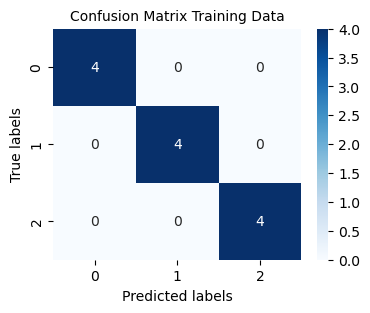

Accuracy of model: 100.00%


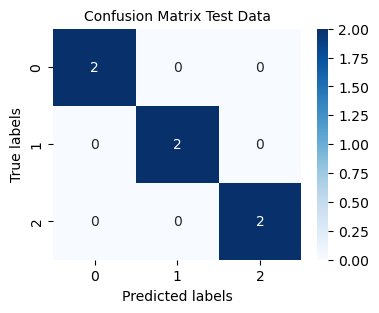

Accuracy of model: 100.00%


In [39]:
y_pred = svm.predict(X_Train)
confusion_mx(Y_Train , y_pred,"Training Data")
print('Accuracy of model: {:.2f}%'.format(getAccuracy(svm, X_Test, Y_Test)))
y_pred = svm.predict(X_Test)
confusion_mx(Y_Test , y_pred,"Test Data")
print('Accuracy of model: {:.2f}%'.format(getAccuracy(svm, X_Test, Y_Test)))

# **2.**

**Reading data**

In [40]:
df = pd.read_csv("car_evaluation.csv" , names = ["buying price" , "maintenance cost" , "number of doors" , "number of persons" , "lug_boot" , "safety" , "decision"])
X = df.drop("decision" , axis = 1)
Y = df["decision"]

## **a) Split the data to shuffled random samples**

*   **1000 training set**
*   **428 testing set**
*   **300 validation set** 

In [41]:
x_train, x_test, y_train, y_test = split_data(X , Y , 1300 , 428)
x_train , x_val , y_train , y_val = split_data(x_train , y_train , 1000 , 300)

## **b) Encode the splitted categorical data into numerical data**

In [42]:
x_train = encode_categorical_df(x_train)
y_train = encode_categorical_column(y_train)
x_test = encode_categorical_df(x_test)
y_test = encode_categorical_column(y_test)
x_val = encode_categorical_df(x_val)
y_val = encode_categorical_column(y_val)

## **c) showing the effect of changing train data size during the training phase on the validation and testing accuracy**

Accuracy for test data :  ['66.59', '67.52', '68.69', '70.09', '71.73', '68.69', '70.79', '69.63', '72.20', '71.73']  % 
Accuracy for validation data :  ['63.67', '69.33', '73.00', '76.67', '77.67', '77.00', '77.67', '75.00', '75.00', '77.33']  % 


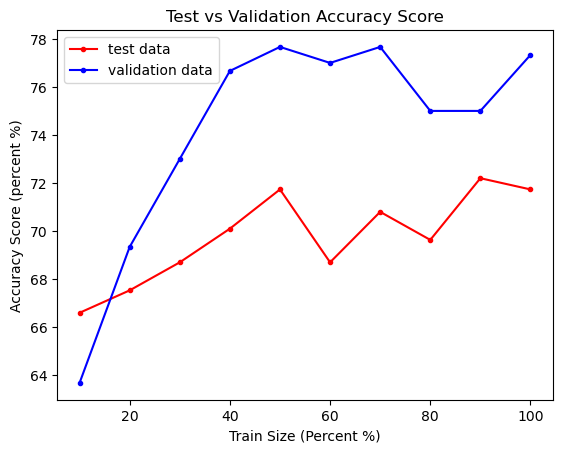

In [43]:
percent_list = [10 , 20 , 30 , 40 , 50 , 60 , 70 ,80 , 90 , 100]
KNN_X_train_size(x_train , y_train , x_test , y_test , x_val , y_val , percent_list)

## **d) showing the effect of changing the number of Ks during the training phase on the validation and testing accuracy**

Accuracy for validation data :  ['81.67', '77.33', '89.33', '87.00', '92.67', '91.00', '91.67', '90.33', '89.00', '88.67']  % 


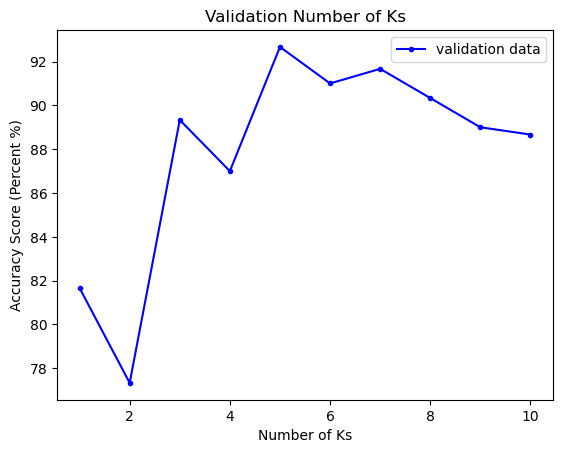

In [44]:
KNN_X_K(x_train , y_train , x_test , y_test , x_val , y_val )